# ***화승***

## ***IMPORT LIBRARY***
---

In [1]:
### Library Import 
import os
import re
import sys
import glob
import shap
import optuna
import pickle
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import xgboost as xgb
from math import ceil
from tqdm import tqdm
from scipy import stats
import statsmodels.api as sm
from functools import partial
from collections import Counter
from pandarallel import pandarallel
from xgboost import XGBRegressor, callback as xgb_callback
from datetime import timedelta, time, datetime
from scipy.stats import truncnorm
from IPython.display import Image
from optbinning import OptimalBinning
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.patches as patches
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
warnings.filterwarnings('ignore')
plt.rc('font', family='Apple SD Gothic Neo')

# Pandas 옵션 설정 
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

# Scikit-Learn 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence 

# Import fns 
from utils import * 
from hwaseung_fn import * 

In [2]:
### Parameters 
path = '/Users/hwijongim/Library/CloudStorage/OneDrive-앰버로드/문서 - Solution/2502_화승/20.수행/22.분석과제/250408_분석_sm'
p_type = 'CMB'
cluster = 4

## ***Load Dataset***
---

In [3]:
### Load Raw Data 
# Data Import 
log_df, qa_df, recipe_df, info, weather_df = import_raw_data(path) 
recipe_origin_df = recipe_df.copy() 

# Print 
print('='*100)
print(f'Log Dataset: {log_df.shape}')
print(f'QA Dataset: {qa_df.shape}')
print(f'Recipe Dataset: {recipe_df.shape}')
print(f'INFO Dataset: {info.shape}')
print(f'Weather Dataset: {weather_df.shape}')
print('='*100)

Log Dataset: (9478081, 37)
QA Dataset: (334291, 16)
Recipe Dataset: (1813072, 13)
INFO Dataset: (80, 2)
Weather Dataset: (1268, 5)


## ***Data Preprocessing***
---

In [4]:
### Log Dataset 정제 
log_df4, log_df5 = prep_log(log_df)

# Print 
print('='*100)
print(f'Log Dataset: {log_df4.shape}')
print(f'Log Train Dataset: {log_df5.shape}')
print('='*100)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Log Dataset: (8566802, 39)
Log Train Dataset: (128985, 18)


In [5]:
### QA Dataset 정제 
qa_df4, qa_df5 = prep_qa(qa_df)

# Print 
print('='*100)
print(f'Qa Dataset: {qa_df4.shape}')
print(f'Qa Train Dataset: {qa_df5.shape}')
print('='*100)

Qa Dataset: (242922, 4)
Qa Train Dataset: (137180, 14)


In [6]:
### Recipe Dataset 정제 
recipe_df = prep_recipe(recipe_origin_df, info) 

# Print 
print('='*100)
print(f'Recipe Dataset: {recipe_df.shape}')
print('='*100)

Recipe Dataset: (123200, 2)


In [7]:
### Concat Dataset 
df1 = pd.merge(left=log_df5, right=qa_df5, on="작업지시번호-배치", how="left")
df2 = pd.merge(left=df1, right=recipe_df, on="작업지시번호-배치", how="left")
df3 = pd.merge(left=df2, right=weather_df, on="연월일", how="left").drop(["연월일"], axis=1)    

# Print 
print('='*100)
print(f'Daset Shape: {df3.shape}')
print('='*100)


Daset Shape: (128985, 35)


In [23]:
### Get Cluster Column 
dataset = create_cluster_col(df3, p_type)  
dataset = dataset[dataset['Cluster']==cluster].reset_index(drop=True).copy()

# Print 
print('='*100)
print(f'Train Dataset Shape: {dataset.shape}')
print('='*100)

Train Dataset Shape: (38, 36)


In [24]:
### Target Value 확인 
# 확인할 컬럼 리스트
target_lst = [
    "cycle time", "Ct 90_결과", "M/B_결과", "M/B_기준",
    "Scorch_결과", "Vm_결과", "경도_결과"
]

# Print 
print('='*100)
print(dataset[target_lst].count())
print('='*100)

cycle time    38
Ct 90_결과       0
M/B_결과         7
M/B_기준         6
Scorch_결과      0
Vm_결과          0
경도_결과          0
dtype: int64


## ***MODELLING***
---

In [30]:
def create_train_test_dataset(df, target, p_type): 
    ''' 
    각 Target을 기준으로 Train Test를 분리하여 결과값을 반환한다 

    Returns: Train_dataset, Test_dataset 
    ''' 
    # Copy 
    dataset = df.reset_index(drop=True).copy() 
    dataset = dataset.dropna(subset=target)

    # Feature Selection 
    cluster_col = ['Cluster'] 
    y_col = target  

    # X Features 
    if p_type=='FMB': 
        X_col = [
            # 'step1_Ram 압력','step2_Ram 압력','step3_Ram 압력',
            'step1_Rotor speed','step2_Rotor speed','step3_Rotor speed',
            'step1_mix온도','step2_mix온도','step3_mix온도',	
            'step1_전력량','step2_전력량','step3_전력량', 
            'step1_time','step2_time','step3_time',
            '필팩터','TA_AVG','TA_MAX','TA_MIN',
            
            ]
    elif p_type=='CMB': 
        X_col = [
            # 'step1_Ram 압력','step2_Ram 압력','step3_Ram 압력',
            'step1_Rotor speed','step2_Rotor speed','step3_Rotor speed',
            'step1_mix온도','step2_mix온도','step3_mix온도',	
            'step1_전력량','step2_전력량','step3_전력량', 
            'step1_time','step2_time','step3_time',
            '필팩터','TA_AVG','TA_MAX','TA_MIN',
            ]
    
    # Define Dataset 
    dataset = dataset[['작업지시번호-배치'] + X_col + cluster_col + [y_col]] 

    # 결측 제거 
    dataset = check_na_counts(dataset) 
    batch = dataset[['작업지시번호-배치']]
    
    # X, y
    X = dataset[X_col]
    y = dataset[y_col] 

    # Train Test Split 
    X_train, X_test, y_train, y_test, b_train, b_test = train_test_split(X, y, batch,
                                                                        test_size=0.19,
                                                                        random_state=22,
                                                                        shuffle=True,
                                                                        )

    # Scaler 제외 변수 정의     
    derived_cols = []
    if p_type == 'FMB':
        derived_cols = ['Vm_feature', 'Scorch_feature', 'Cluster']
    elif p_type == 'CMB':
        derived_cols = ['MB_feature', 'Cluster']

    # Scaler Cols 
    exclude_cols = set(derived_cols)

    # Scaler 적용 
    scale_cols = [col for col in X_train.columns if col not in exclude_cols]

    # Scaler 
    scaler = StandardScaler()
    X_train_scaled = X_train.copy() 
    X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols]) 

    X_test_scaled = X_test.copy() 
    X_test_scaled[scale_cols] = scaler.transform(X_test[scale_cols])  

    # 반환용 DF 구성 (batch + X + y)
    train_df = pd.concat(
        [b_train.reset_index(drop=True),
         X_train_scaled.reset_index(drop=True),
         y_train.reset_index(drop=True)], axis=1
    ).rename(columns={'작업지시번호-배치': '작업지시번호-배치'})

    test_df = pd.concat(
        [b_test.reset_index(drop=True),
         X_test_scaled.reset_index(drop=True),
         y_test.reset_index(drop=True)], axis=1
    ).rename(columns={'작업지시번호-배치': '작업지시번호-배치'})

    return train_df, test_df, scaler, scale_cols


In [32]:
### Train Test Split 
# Targets 
targets = ['cycle time','M/B_결과']

# cycle time 
cycle_train_dataset, cycle_test_dataset, cycle_scaler, cycle_scaler_cols = create_train_test_dataset(dataset, targets[0], p_type='CMB')

# M/B 
mb_train_dataset, mb_test_dataset, mb_scaler, mb_scaler_cols = create_train_test_dataset(dataset, targets[1], p_type='CMB')

# Print 
print('='*100)
print(f"{'cycle time':<21} | {len(cycle_train_dataset):>14,} | {len(cycle_test_dataset):>13,}")
print(f"{'M/B_결과':<20} | {len(mb_train_dataset):>14,} | {len(mb_test_dataset):>13,}")
print("="*100) 

cycle time            |             30 |             8
M/B_결과               |              5 |             2


[I 2025-10-31 10:55:42,322] A new study created in memory with name: no-name-89094dd8-aed8-439b-b18b-449f44df1abf


학습할 Tree Features: 16 | ['step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN']
학습 Tree 데이터 수: 30


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-31 10:55:42,677] Trial 0 finished with value: 17.769655745810976 and parameters: {'n_estimators': 1807, 'max_depth': 9, 'learning_rate': 0.008628578505052373, 'subsample': 0.8695715627757821, 'gamma': 0.03698666430384018, 'reg_lambda': 0.004950405030188996}. Best is trial 0 with value: 17.769655745810976.
[I 2025-10-31 10:55:42,891] Trial 1 finished with value: 54.534610356990505 and parameters: {'n_estimators': 1666, 'max_depth': 8, 'learning_rate': 0.0010381961184293099, 'subsample': 0.8186265954094054, 'gamma': 0.0741175177862583, 'reg_lambda': 2.1431755752226502}. Best is trial 0 with value: 17.769655745810976.
[I 2025-10-31 10:55:43,246] Trial 2 finished with value: 18.96082681702892 and parameters: {'n_estimators': 2355, 'max_depth': 11, 'learning_rate': 0.008314006278279596, 'subsample': 0.7383573861994909, 'gamma': 0.42549294958668066, 'reg_lambda': 0.04598427286942189}. Best is trial 0 with value: 17.769655745810976.
[I 2025-10-31 10:55:43,394] Trial 3 finished with

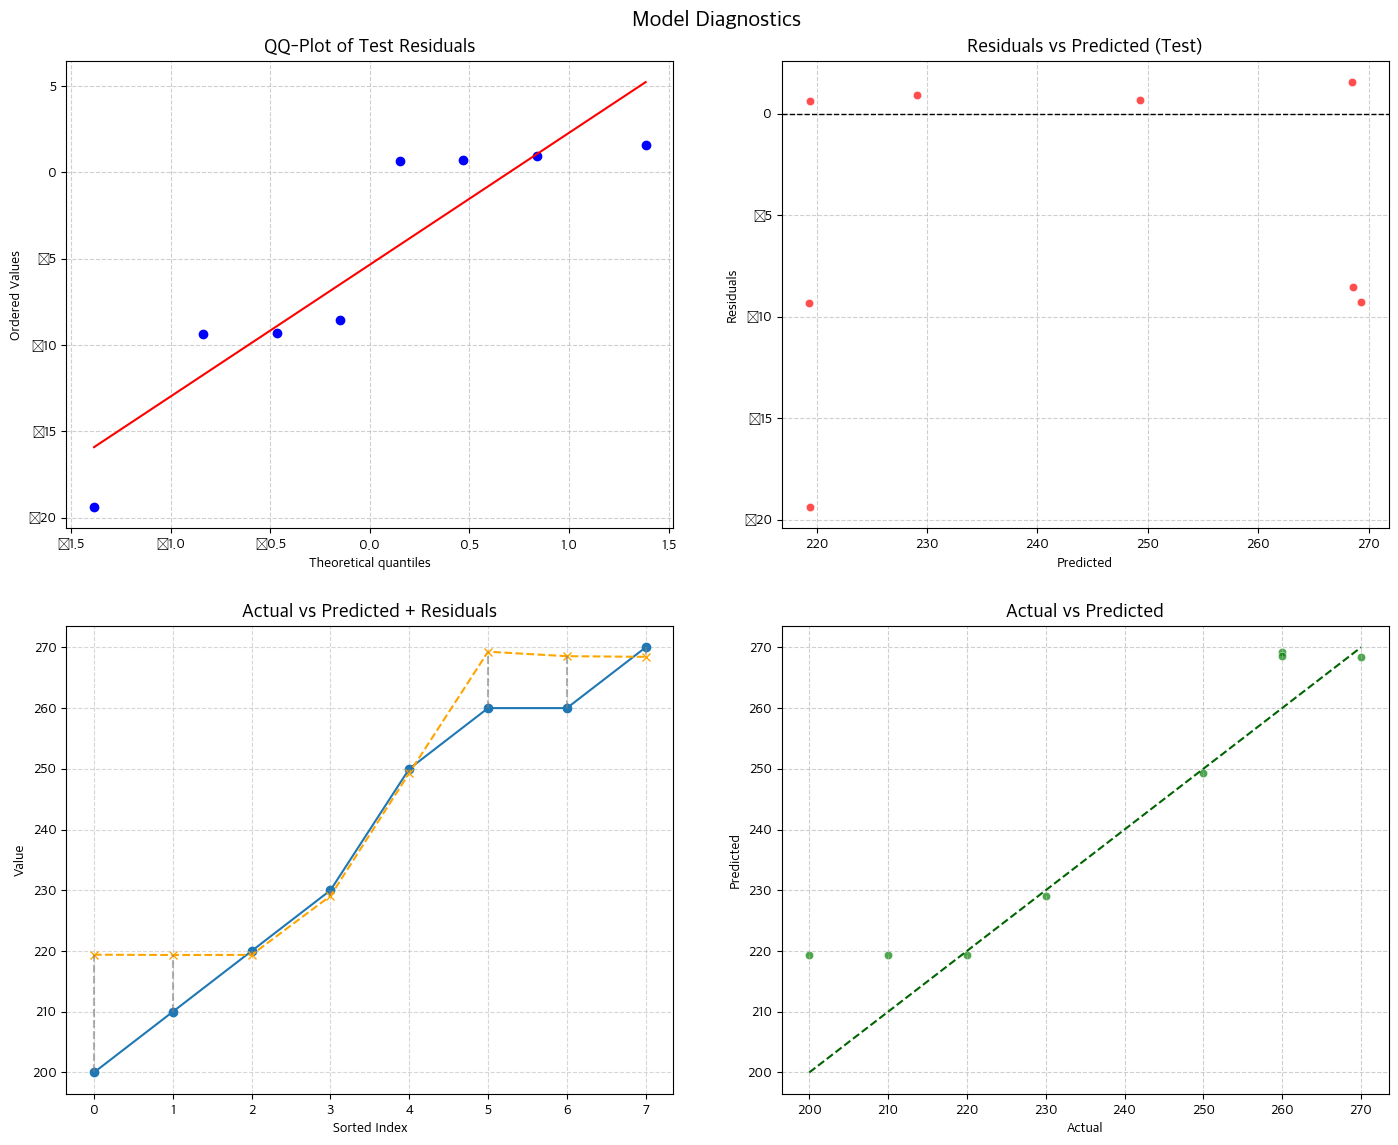

[I 2025-10-31 10:55:46,251] A new study created in memory with name: no-name-a60d6b33-454d-48b6-afa5-b1dcd22606d9


Train Accuracy
Train RMSE : 0.819
Train R2   : 1.000
Train SMAPE : 0.30
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 8.851
Test R2   : 0.868
Test SMAPE : 2.74
학습할 Tree Features: 16 | ['step1_Rotor speed', 'step2_Rotor speed', 'step3_Rotor speed', 'step1_mix온도', 'step2_mix온도', 'step3_mix온도', 'step1_전력량', 'step2_전력량', 'step3_전력량', 'step1_time', 'step2_time', 'step3_time', '필팩터', 'TA_AVG', 'TA_MAX', 'TA_MIN']
학습 Tree 데이터 수: 5


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-31 10:55:46,572] Trial 0 finished with value: 0.22574691772461009 and parameters: {'n_estimators': 2388, 'max_depth': 9, 'learning_rate': 0.08580678500810353, 'subsample': 0.7936155287213653, 'gamma': 0.2917278871774145, 'reg_lambda': 0.005089197482048395}. Best is trial 0 with value: 0.22574691772461009.
[I 2025-10-31 10:55:46,771] Trial 1 finished with value: 0.18599205017089915 and parameters: {'n_estimators': 1323, 'max_depth': 10, 'learning_rate': 0.17346218974720545, 'subsample': 0.9306346989371698, 'gamma': 0.2608714924554862, 'reg_lambda': 0.014405909958935982}. Best is trial 1 with value: 0.18599205017089915.
[I 2025-10-31 10:55:46,883] Trial 2 finished with value: 0.2053497314453132 and parameters: {'n_estimators': 798, 'max_depth': 10, 'learning_rate': 0.013046410050185406, 'subsample': 0.9207001765677085, 'gamma': 0.16232813587840872, 'reg_lambda': 1.8164800433012607}. Best is trial 1 with value: 0.18599205017089915.
[I 2025-10-31 10:55:47,152] Trial 3 finished w

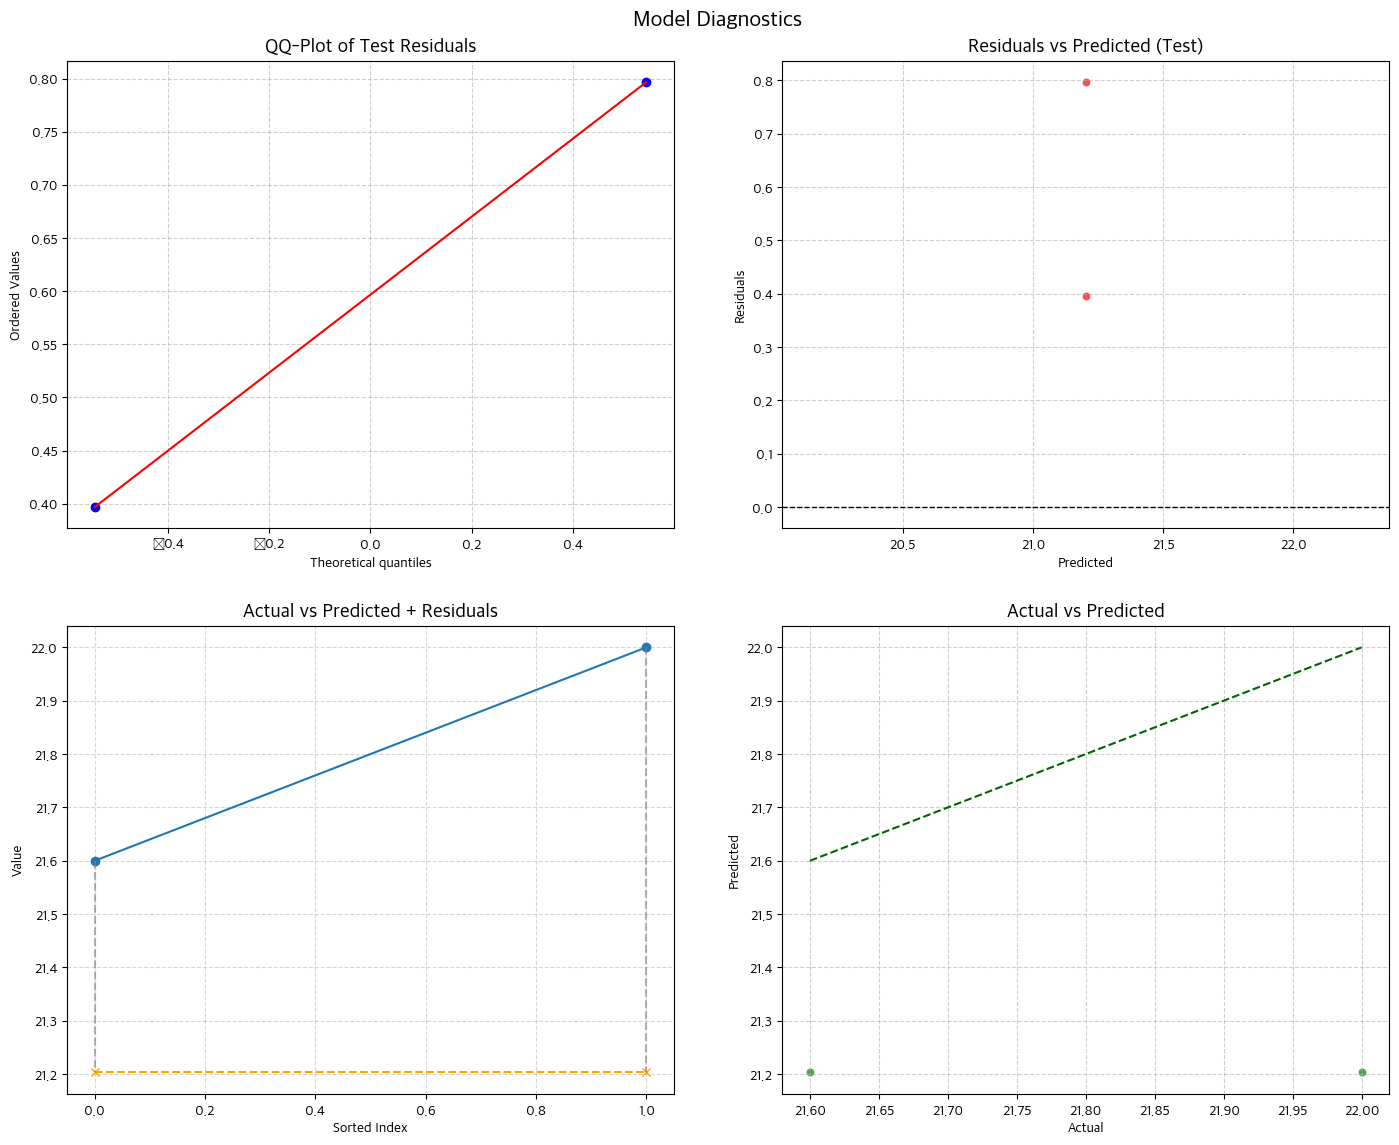

Train Accuracy
Train RMSE : 0.324
Train R2   : -0.424
Train SMAPE : 1.03
----------------------------------------------------------------------------------------------------
Test Accuracy
Test RMSE : 0.629
Test R2   : -8.902
Test SMAPE : 2.77


In [33]:
### Modelling 
# cycle time 
cycle_model, cycle_importance = train_tree(cycle_train_dataset, cycle_test_dataset, target_col='cycle time')

# M/B 
mb_model, mb_importance = train_tree(mb_train_dataset, mb_test_dataset, target_col='M/B_결과')


In [41]:
### Shap Tree 적용 
# M/B
mb_shap_values, mb_filtered_dataset, mb_feature_importance = shap_tree(dataset, mb_scaler, mb_scaler_cols, mb_model, p_type, target_col=targets[1], cluster=cluster)

# Voting 
feature_importances = [mb_feature_importance]
cluster_feature_importance = voting_feature_importance(feature_importances) 

# Print 
print('='*100)
print(f'Cluster {cluster} Shap Tree Feature Importance 추출 완료')
print('='*100)

Cluster 4 | M/B_결과 => Feature Importance 추출 시작
Cluster 조건 적용된 데이터 수: (6, 19)
Optimal Target 조건 적용된 데이터 수: (0개, std=1.00%)
Optimal Target 조건 적용된 데이터 수: (0개, std=3.00%)
Optimal Target 조건 적용된 데이터 수: (0개, std=5.00%)
⚠️ fallback: std=5.00%, 수=0
모든 조건이 필터링된 데이터 수: (0, 19)
Cluster 4 Shap Tree Feature Importance 추출 완료


In [42]:
cycle_importance

,Feature,Importance,rank
0,step3_전력량,0.911443,1
1,step3_time,0.056400,2
2,step3_mix온도,0.015539,3
3,step1_전력량,0.009202,4
4,step1_time,0.003597,5
5,step1_mix온도,0.001999,6
6,step2_전력량,0.001171,7
7,step1_Rotor speed,0.000299,8
8,step2_mix온도,0.000167,9
9,필팩터,0.000080,10
